# Comparative Analysis
In this notebook, we compare Window with different window size detection techniques.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import pandas as pd
import daproli as dp

import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import Orange
import sys
sys.path.append("../")

from tqdm import tqdm

Let's choose a score for evaluation (F1 or Covering).

In [3]:
eval_score = "f1_score"

Let's load the scores from the different methods.

In [4]:
wsd = ["Human", "FFT", "ACF", "SuSS", "MWF", "Autoperiod", "RobustPeriod"] # 

methods = list()

for algo in wsd:
    candidate_name = f"window_{algo}"
    methods.append((algo, f"{candidate_name}.csv"))

for idx, (name, file_name) in enumerate(methods):
    methods[idx] = name, pd.read_csv(f"../experiments/segmentation/window/{file_name}")
    
df_scores = pd.DataFrame()

for name, df in methods:
    df_scores["name"] = df.name
    df_scores[name] = df[eval_score]

Let's calculate the mean/std score.

In [5]:
df_scores.mean(axis=0)

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_2386/3665851733.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_scores.mean(axis=0)


Human           0.432217
FFT             0.419723
ACF             0.435108
SuSS            0.452735
MWF             0.392627
Autoperiod      0.399831
RobustPeriod    0.392157
dtype: float64

In [6]:
df_scores.std(axis=0)

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_2386/2176364554.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_scores.std(axis=0)


Human           0.220700
FFT             0.222331
ACF             0.213818
SuSS            0.207864
MWF             0.225398
Autoperiod      0.221187
RobustPeriod    0.253676
dtype: float64

Let's compute the wins per method.

In [7]:
ranks = df_scores.rank(1, method = 'min', ascending=False)
means = np.array(ranks.mean(axis=0))

In [8]:
for mean, name in zip(means, df_scores.columns[1:]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 5)}")

Human:wins=58 rank=1.6506
FFT:wins=54 rank=1.49398
ACF:wins=59 rank=1.44578
SuSS:wins=65 rank=1.3494
MWF:wins=51 rank=1.74699
Autoperiod:wins=53 rank=1.75904
RobustPeriod:wins=52 rank=2.14458


Let's plot and output the ranks.

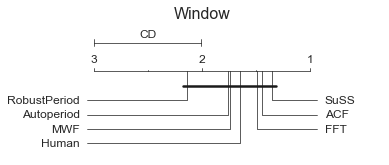

In [9]:
cd = Orange.evaluation.scoring.compute_CD(means, df_scores.shape[0])
Orange.evaluation.scoring.graph_ranks(means, df_scores.columns[1:], cd=cd, highv=3, width=5, reverse=True, textspace=1, ) # filename="../tmp/comparative-analysis.pdf"
plt.title("Window", fontsize=16)
plt.savefig(f"../tmp/cd_window.pdf", bbox_inches="tight")
plt.show()

Let's compute wins/losses against ClaSP.

In [10]:
selection = "Human"

for rival in df_scores.columns[1:]:
    if rival == selection: continue
    
    df_pair = df_scores[[selection, rival]]
    pair_ranks = df_pair.rank(1, method = 'min', ascending=False)
    
    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]
    
    assert wins + losses + ties == pair_ranks.shape[0]
    
    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

Human vs FFT: (wins/ties/losses): 9/68/6
Human vs ACF: (wins/ties/losses): 9/63/11
Human vs SuSS: (wins/ties/losses): 10/57/16
Human vs MWF: (wins/ties/losses): 13/63/7
Human vs Autoperiod: (wins/ties/losses): 13/63/7
Human vs RobustPeriod: (wins/ties/losses): 15/61/7


No handles with labels found to put in legend.


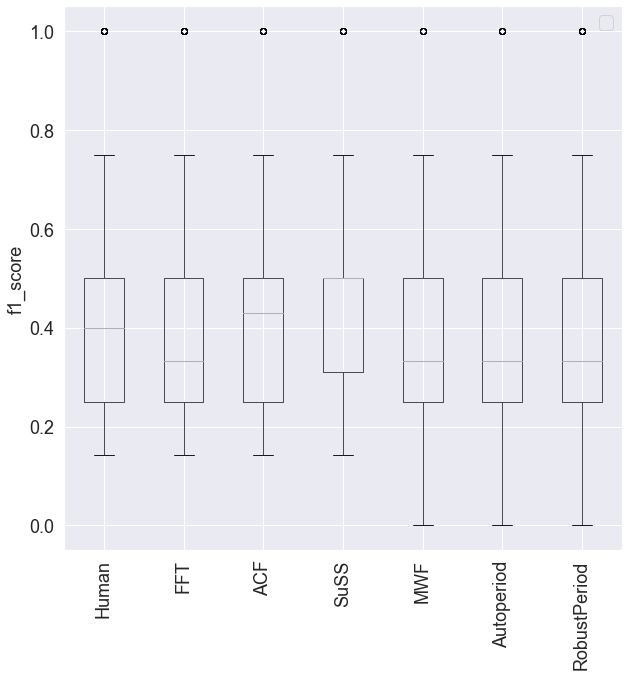

In [11]:
fontsize = 18
_, ax = plt.subplots(figsize=(10,10))

df_scores.boxplot(ax=ax, rot=90)
ax.set_ylabel(eval_score, fontsize=fontsize)

ax.legend(prop={'size': fontsize})

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
    
# plt.savefig(f"../tmp/comparative_analysis_boxplot.pdf", bbox_inches="tight") 